In [81]:
# Import the libraries

import os
import sys
from IPython.display import HTML, display

import numpy as np
import pandas as pd
import tensorflow as tf
from math import ceil
from scipy.spatial.distance import cosine

import matplotlib.pyplot as plt
import seaborn as sns

import collections
import random
import time
import string
import re

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Embedding, Dense, Convolution1D, MaxPooling1D, GlobalMaxPooling1D, Flatten, Dropout, LSTM, Bidirectional

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Shane\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Shane\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Shane\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Data Preprocessing

In [82]:
# Progress bar
def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

# Save a word2vec dictionary.
def save_word2vec(filename):
    with open(os.path.join('/Users/haoxing/Documents/Work/Teaching/Machine learning for Finance/Codes/NLP/NLP_app', filename),'a' , encoding='utf-8') as f :
        for k, v in word2vec.items():
            line = k+' '+str(list(v)).strip('[]').replace(',','')+'\n'
            f.write(line)

# Load a word2vec dictionary.
def load_word2vec(filename):
    word2vec = {}
    with open(os.path.join('/Users/haoxing/Documents/Work/Teaching/Machine learning for Finance/Codes/NLP/NLP_app', filename), encoding='utf8') as f:
        for line in f:
            try :
                values = line.split()
                word = values[0]
                vec = np.asarray(values[1:], dtype='float32')
                word2vec[word] = vec
            except :
                None
    return word2vec

# read the repo in PATH and append the texts in a list
def get_data(PATH):
    list_dir = os.listdir(PATH)
    texts = []
    fund_names = []
    out = display(progress(0, len(list_dir)-1), display_id=True)
    for ii, filename in enumerate(list_dir) :
        with open(PATH+'/'+filename, 'r', encoding="utf8") as f :
            txt = f.read()
            try :
                txt_split = txt.split('<head_breaker>')
                summary = txt_split[1].strip()
                fund_name = txt_split[0].strip()
            except :
                summary = txt
                fund_name = ''
        texts.append(summary)
        fund_names.append(fund_name)
        out.update(progress(ii, len(list_dir)-1))
    return fund_names, texts

In [83]:
SUMMARY_PATH = 'MutualFundSummary'
SUMMARY_LABELS_PATH = 'MutualFundLabels.csv'

In [84]:
fund_names, summaries = get_data(SUMMARY_PATH)

In [85]:
df_label = pd.read_csv(SUMMARY_LABELS_PATH)
df_label.head()

,id,fund_name,Performance fee?,Ivestment Strategy,Leverage?,Portfolio composition,Concentration
0,0000051931-18-000151,American Funds College 2018 Fund,None,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified
1,0000051931-18-000151,American Funds College 2021 Fund,None,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified
2,0000051931-18-000151,American Funds College 2024 Fund,None,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified
3,0000051931-18-000151,American Funds College 2027 Fund,None,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified
4,0000051931-18-000151,American Funds College 2030 Fund,None,Balanced Fund (Low Risk),Yes,Investment grade securities,Diversified


In [86]:
# test dataset: the fund that did not have a label but is in the folder of summaries
test_funds = [fund for fund in fund_names if fund not in list(df_label['fund_name'])]
test_index = [fund_names.index(fund) for fund in fund_names if fund not in list(df_label['fund_name'])]

test_summaries = [summary for summary in summaries if summaries.index(summary) in test_index]

In [87]:
len(test_funds)

79

In [88]:
len(test_summaries)

79

In [89]:
df_label['Ivestment Strategy'].value_counts()

Equity Long Only (Low Risk)          248
Fixed Income Long Only (Low Risk)    130
Balanced Fund (Low Risk)              84
Long Short Funds (High Risk)           4
Commodities Fund (Low Risk)            1
Name: Ivestment Strategy, dtype: int64

In [90]:
#The only four high-risk fund and only one commodities should be removed from our model for it has too small amounts
remove_fund = df_label.loc[(df_label['Ivestment Strategy']=='Long Short Funds (High Risk)') | (df_label['Ivestment Strategy']=='Commodities Fund (Low Risk)'),'fund_name']
print(remove_fund)
remove_index = [fund_names.index(fund) for fund in fund_names if fund in list(remove_fund)]
remove_index

296                   Columbia Commodity Strategy Fund
301               Columbia Mortgage Opportunities Fund
423             Anchor Tactical Equity Strategies Fund
424          Anchor Tactical Municipal Strategies Fund
425    Dreyfus Alternative Diversifier Strategies Fund
Name: fund_name, dtype: object


[84, 85, 102, 112, 148]

In [91]:
#The second model:keep the four high-risk fund
remove_fund1 = df_label.loc[df_label['Ivestment Strategy']=='Commodities Fund (Low Risk)','fund_name']
print(remove_fund1)
remove_index1 = [fund_names.index(fund) for fund in fund_names if fund in list(remove_fund1)]
remove_index1

296    Columbia Commodity Strategy Fund
Name: fund_name, dtype: object


[102]

In [92]:
keep_funds = [fund for fund in fund_names if fund not in list(remove_fund)]
keep_fund_summaries = [summary for summary in summaries if summaries.index(summary) not in remove_index]
keep_funds1 = [fund for fund in fund_names if fund not in list(remove_fund1)]
keep_fund_summaries1 = [summary for summary in summaries if summaries.index(summary) not in remove_index1]

In [93]:
print(len(keep_funds),len(keep_fund_summaries))
print(len(keep_funds1),len(keep_fund_summaries1))

540 540
544 544


In [94]:
df_summary = pd.DataFrame(data={'fund_name':keep_funds, 'summary':keep_fund_summaries}) 
df_summary1 = pd.DataFrame(data={'fund_name':keep_funds1, 'summary':keep_fund_summaries1}) 

In [95]:
df_merge = df_summary.merge(df_label, on =['fund_name'], how ='left').dropna()
df_merge1 = df_summary1.merge(df_label, on =['fund_name'], how ='left').dropna()

In [96]:
df_merge['Ivestment Strategy'].value_counts()

Equity Long Only (Low Risk)          247
Fixed Income Long Only (Low Risk)    130
Balanced Fund (Low Risk)              84
Name: Ivestment Strategy, dtype: int64

In [97]:
df_merge1['Ivestment Strategy'].value_counts()

Equity Long Only (Low Risk)          247
Fixed Income Long Only (Low Risk)    130
Balanced Fund (Low Risk)              84
Long Short Funds (High Risk)           4
Name: Ivestment Strategy, dtype: int64

In [98]:
df_merge.tail()

,fund_name,summary,id,Performance fee?,Ivestment Strategy,Leverage?,Portfolio composition,Concentration
533,Variable Portfolio - Wells Fargo Short Duratio...,SUMMARY OF CTIVPSM – WELLS FARGO SHORT DURATIO...,0001193125-18-139001,None,Fixed Income Long Only (Low Risk),Yes,Investment grade securities,Diversified
536,Western Asset Intermediate Maturity California...,Investment objective\n\nThe fund seeks to prov...,0001193125-18-091654,None,Fixed Income Long Only (Low Risk),Yes,Investment grade securities,Concentrated by issuer / sector / jurisdiction
537,Western Asset Intermediate Maturity New York M...,Investment objective\n\nThe fund seeks to prov...,0001193125-18-091654,None,Fixed Income Long Only (Low Risk),Yes,Investment grade securities,Concentrated by issuer / sector / jurisdiction
538,Western Asset Massachusetts Municipals Fund,Investment objective\n\nThe fund seeks to prov...,0001193125-18-091654,None,Fixed Income Long Only (Low Risk),Yes,Investment grade securities,Concentrated by issuer / sector / jurisdiction
539,World Growth Fund,INVESTMENT OBJECTIVE\nThe USAA World Growth Fu...,0001683863-18-000339,Some performance Fees,Equity Long Only (Low Risk),No,Sub-investment grade securities or emerging ma...,Diversified


In [99]:
X_train, X_valid, y_train, y_valid = train_test_split(df_merge['summary'], df_merge['Ivestment Strategy'], test_size=0.3, random_state=42)

In [100]:
X_train1, X_valid1, y_train1, y_valid1 = train_test_split(df_merge1['summary'], df_merge1['Ivestment Strategy'], test_size=0.3, random_state=22)

In [101]:
len(X_train)

322

In [102]:
len(X_valid)

139

In [103]:
len(X_train1)

325

In [104]:
# stop words set
stop_words = set(stopwords.words("english")+list(string.punctuation)+['``',"''"]+["]","[","*"]+['doe', 'ha', 'wa'])

def tokenizer(txt):
    """tokenizer

    Args:
        txt (str): text to be tokenized

    Returns:
        filtered_sentence (list): list of tokenized string.  
    """
    txt = txt.lower().replace('\t', ' ').replace('\n', ' ')
    word_tokens = word_tokenize(txt)
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    filtered_sentence = [w for w in filtered_sentence if re.sub("[^A-Za-z ]+",'',w) != ''] 
    return filtered_sentence
    
train_text_words = np.concatenate([tokenizer(s) for s in X_train])
    

## skip-gram model

In [105]:
# training parameters for skip-gram model
batch_size = 120
num_epochs = 2
# word2vec parameters
embedding_size = 50 # size of embedding vector
max_vocabulary_size = 5000 #  number of different words in vocabulary
min_occurrence = 10 # words must appear at least 10 times
skip_window = 3 # how many words to consider left and right
num_skips = 4 # how many times to reuse an input to generate a label

In [106]:
# Build the dictionary and replace rare words with UNK token
count = [('UNK', -1)]
# Count the most common words
count.extend(collections.Counter(train_text_words).most_common(max_vocabulary_size - 1))
# Remove samples with less than 'min_occurrence' occurrences
for i in range(len(count) - 1, -1, -1):
    if count[i][1] < min_occurrence:
        count.pop(i)
    else:
        # The collection is ordered, so stop when 'min_occurrence' is reached
        break

In [107]:

# give a unique id to each words in the vocabulary
word2id = dict()
for i, (word, _)in enumerate(count):
    word2id[word] = i
id2word = dict(zip(word2id.values(), word2id.keys()))
vocab_size = len(id2word)

unk_count = 0 # we still need to count the unkown words(the words that are not in the word2id)
data = [] # turn words in train_text_words into id numbers and put them in data

for word in train_text_words:
    index = word2id.get(word, 0)
    if index == 0: # if can't find the word in word2id
        unk_count += 1
    data.append(index) # append the id number
count[0] = ('UNK', unk_count) # update the UNK value of count

In [108]:
def to_one_hot(data_point_index, vocab_size):
    one_hot = np.zeros(vocab_size)
    one_hot[data_point_index] = 1
    return one_hot

def batch_generator(batch_size, num_skips, skip_window, vocab_size):
    """function to generator batch for model training

    Args:
        batch_size (int): size of batch
        num_skips (int): how many times to reuse an input to generate a label
        skip_window (int): how many words to consider left and right
        vocab_size (int): size of the word2id/id2word
    Yields:
        batch_one_hot
        labels_one_hot
    """    
    data_idx = 0
    while True:
        assert num_skips <= 2 * skip_window
        assert batch_size % num_skips == 0
        labels = np.ndarray(shape=(batch_size), dtype=np.int32)
        batch = np.ndarray(shape=(batch_size), dtype=np.int32)
        span = skip_window * 2 + 1
        buffer = collections.deque(maxlen=span) #keep track of the visited indexes visited
        if data_idx + span > len(data):
            data_idx = 0
            # stop the loop
            break
        buffer.extend(data[data_idx:data_idx + span])
        data_idx += span
        for i in range(batch_size // num_skips):  
            # Take the context current word
            context_words = [w for w in range(span) if w != skip_window]
            # sample num_skips number of words
            words_to_use = random.sample(context_words, num_skips)
            for j, context_word in enumerate(words_to_use):
                batch[i * num_skips + j] = buffer[skip_window]
                labels[i * num_skips + j] = buffer[context_word]
            if data_idx == len(data):
                buffer.extend(data[0:span])
                data_idx = span
            else:
                buffer.append(data[data_idx])
                data_idx += 1
        
        data_idx = (data_idx + len(data) - span) % len(data)

        # translate word index to on-hot
        batch_one_hot = np.array([to_one_hot(b, vocab_size) for b in batch])
        labels_one_hot = np.array([to_one_hot(l, vocab_size) for l in labels])
        
        yield batch_one_hot, labels_one_hot # output one batch

In [109]:
# train the skip-gram model
def word2vec_model():
    input_w = Input(shape = (vocab_size,))
    encoded = Dense(embedding_size, activation='linear')(input_w)
    decoded = Dense(vocab_size, activation='softmax')(encoded)
    autoencoder = Model(input_w, decoded)
    encoder = Model(input_w, encoded)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    return encoder, autoencoder

encoder, autoencoder = word2vec_model()

In [110]:
autoencoder.fit(x = batch_generator(batch_size, num_skips, skip_window, vocab_size), steps_per_epoch=ceil(len(data) / batch_size), epochs=num_epochs)


Epoch 1/2
4682/4682 [==============================] - 33s 7ms/step - loss: 0.0192
Epoch 2/2
4682/4682 [==============================] - 33s 7ms/step - loss: 0.0026


In [111]:
def save_word2vec(filename):
    with open(os.path.join('', filename),'a' , encoding='utf-8') as f :
        for k, v in word2vec.items():
            line = k+' '+str(list(v)).strip('[]').replace(',','')+'\n'
            f.write(line)

# Load a word2vec dictionary.
def load_word2vec(filename):
    word2vec = {}
    with open(os.path.join('', filename), encoding='utf8') as f:
        for line in f:
            try :
                values = line.split()
                word = values[0]
                vec = np.asarray(values[1:], dtype='float32')
                word2vec[word] = vec
            except :
                None
    return word2vec

In [112]:
# use the encoder to vectorize
def vecotrize(word):
    w_one_hot = to_one_hot(word2id[word], vocab_size)
    return encoder.predict(np.array([w_one_hot]))[0]

# create the word2vec dictionary then save it.
word2vec = {w : vecotrize(w) for w in word2id.keys()}
save_word2vec('train_word2vec')

1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step


In [113]:
def lemma_tokenizer(text):
    lemmatizer=WordNetLemmatizer()
    return [lemmatizer.lemmatize(token) for token in word_tokenize(text.replace("'"," "))]

stop_words = set(stopwords.words("english")+list(string.punctuation)+['``',"''","’"]+["]","[","*"]+['doe', 'ha', 'wa'] +['--']+ [''])

In [114]:
max_features = 18
tfidf = TfidfVectorizer(input='content', tokenizer=lemma_tokenizer, stop_words=stop_words, max_features=max_features)
tfidf1 = TfidfVectorizer(input='content', tokenizer=lemma_tokenizer, stop_words=stop_words, max_features=max_features)
# Fits the tfidf vecotizer on the train sample and create the training features.

tfidf_train = tfidf.fit_transform(X_train) #update
# Uses the vectorizer to create the test features.
tfidf_train1 = tfidf1.fit_transform(X_train1)

In [115]:
key_words = tfidf.get_feature_names() # Common keywords
print(key_words)
key_words1 = tfidf1.get_feature_names() # Common keywords
print(key_words1)

['class', 'company', 'expense', 'fee', 'fund', 'investment', 'market', 'may', 'performance', 'portfolio', 'rate', 'return', 'risk', 'security', 'share', 'tax', 'value', 'year']
['class', 'company', 'expense', 'fee', 'fund', 'index', 'investment', 'market', 'may', 'portfolio', 'rate', 'return', 'risk', 'security', 'share', 'tax', 'value', 'year']


D:\Python\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [116]:
def get_n_closer(word, n, word2vec):
    vect = word2vec[word]
    dist_dict = {k: cosine(v, vect) for k, v in word2vec.items()}
    closer_words = []
    for _ in range(n):
        min_key = min(dist_dict.keys(), key=lambda k: dist_dict[k])
        closer_words.append(min_key)
        del dist_dict[min_key]
    return closer_words

##knowledge base
def create_knowledge_base(num_neighbors, word2vec, key_words):
    knowledge_base = set()
    out = display(progress(0, len(key_words)-1), display_id=True)
    for ii, key_word in enumerate(key_words) :
        knowledge_base.add(key_word)
        neighbors = []
        try :
            neighbors = get_n_closer(key_word, num_neighbors, word2vec)
        except :
            print(key_word + ' not in word2vec')

        knowledge_base.update(neighbors)
        
        out.update(progress(ii, len(key_words)-1))
    return knowledge_base
            

In [117]:
knowledge_base = create_knowledge_base(5, word2vec, key_words)
knowledge_base1 = create_knowledge_base(5, word2vec, key_words1)
print(knowledge_base)
print(knowledge_base1)

{'repaying', 'using', 'plans', 'nrsro', 'style', 'adjustments', 'board', 'rate', 'distributions', 'r', 'fee', 'quickly', 'distribute', 'c', 'path', 'divided', 'may', 'investment', 'affiliated', 'yield', 'class', 'company', 'views', 'year', 'performance', 'day-to-day', 'security', 'downgrades', 'fund', 'approaches', 'registration', 'affiliates', 'qualifying', 'margin', 'estate-linked', 'subsidiaries', 'market', 'responses', 'tax', 'compares', 'dividend-paying', 'designed', 'subadviser', 'eligible', 'occupancy', 'see', 'weakness', 'coverdell', 'movement', 'desired', 'standard', 'insufficient', 'share', 'able', 'reduction', 'reits', 'risk', 'extensive', 'otherwise', 'brokerage', 'aggressive', 'exactly', 'buyer', 'levels', 'return', 'separate', 'segment', 'favor', 'nondiversified', 'earned', 'waiving', 'adviser/portfolio', 'predictable', 'consisting', 'continuing', 'borne', 'originally', 'value', 'expense', 'focuses', 'inst', 'downturn', 'trusts', 'portfolio', 'timely', 'shares', 'preserva

In [118]:
# Takes a summary, the knowledge base and some hyper parameters and returns the "num_sent" sentences
# of the summary that are closer to the the knowledge base in term of spacial distances.
def extract_sentence_distance(summary, knowledge, n_closer, n_reject, num_sent):
    # Split the summary into sentences.
    sentences = sent_tokenize(summary)
    sentence_scores = []
    # Loop over the sentences.
    for j, sentence in enumerate(sentences):
        # we tokenize and clean the sentence
        tokens = tokenizer(sentence)

        sentence_barycentre = np.zeros(embedding_size)
        effective_len = 0
        # Compute the barycentre of the sentence
        for token in tokens :
            try :
                sentence_barycentre += np.array(word2vec[token])
                effective_len += 1
            except KeyError :
                pass
            except :
                raise
        
        # Reject sentences with less than n_reject words in our word2vec map
        if effective_len <= n_reject :
            sentence_scores.append(1)    

        else :
            sentence_barycentre = sentence_barycentre/effective_len
            # Compute the distance sentece_barycentre -> words in our knowledge base
            barycentre_distance = [cosine(sentence_barycentre, word2vec[key_word]) for key_word in knowledge]
            barycentre_distance.sort()
            # Create the score of the sentence by averaging the "n_closer" smallest distances
            score = np.mean(barycentre_distance[:n_closer])
            sentence_scores.append(score)
    # Select the "num_sent" sentences that have the smallest score (smallest distance score with the knowledge base)
    sentence_scores, sentences = zip(*sorted(zip(sentence_scores, sentences)))
    top_sentences = sentences[:num_sent]
    return ' '.join(top_sentences)



## Q4 Measure Distance

In [119]:
#prepare the train,validation and test dataframe
X_train_df = pd.DataFrame(X_train)
X_valid_df = pd.DataFrame(X_valid)
X_train_df1 = pd.DataFrame(X_train1)
X_valid_df1 = pd.DataFrame(X_valid1)
X_test_df = pd.DataFrame({'summary':test_summaries})
X_test_df1 = pd.DataFrame({'summary':test_summaries})

In [120]:
X_test_df

,summary
0,AB ALL MARKET INCOME PORTFOLIO\n--------------...
1,AB ALL MARKET REAL RETURN PORTFOLIO\n---------...
2,AB Arizona Portfolio\n------------------------...
3,AB ASIA EX-JAPAN EQUITY PORTFOLIO\n-----------...
4,AB VPS BALANCED WEALTH STRATEGY PORTFOLIO\n---...
...,...
74,SUMMARY\n\nInvestment Objective\n\nThe fund se...
75,SUMMARY\n\nInvestment Objective\n\nThe fund se...
76,Fund Summary\nInvestment Objective \nThe fund ...
77,INVESTMENT OBJECTIVE\n\n \n\nVirtus Enhanced U...


In [121]:
X_train_df['sentences_distance'] = X_train_df.apply(lambda x : extract_sentence_distance(x['summary'], knowledge_base, n_closer=10, n_reject=5, num_sent=5), axis=1)
X_valid_df['sentences_distance'] = X_valid_df.apply(lambda x : extract_sentence_distance(x['summary'], knowledge_base, n_closer=10, n_reject=5, num_sent=5), axis=1)
X_train_df1['sentences_distance'] = X_train_df1.apply(lambda x : extract_sentence_distance(x['summary'], knowledge_base1, n_closer=10, n_reject=5, num_sent=5), axis=1)
X_valid_df1['sentences_distance'] = X_valid_df1.apply(lambda x : extract_sentence_distance(x['summary'], knowledge_base1, n_closer=10, n_reject=5, num_sent=5), axis=1)

In [122]:
X_test_df['sentences_distance'] = X_test_df.apply(lambda x : extract_sentence_distance(x['summary'], knowledge_base, n_closer=10, n_reject=5, num_sent=5), axis=1)
X_test_df1['sentences_distance'] = X_test_df1.apply(lambda x : extract_sentence_distance(x['summary'], knowledge_base1, n_closer=10, n_reject=5, num_sent=5), axis=1)

In [123]:
def extract_sentence_match(summary, knowledge, num_sent):
    sentences = sent_tokenize(summary)
    sentence_scores = []
    for j, sentence in enumerate(sentences):
        set_tokens = set(tokenizer(sentence))

        # Find the number of common words between the knowledge base and the sentence
        inter_knwoledge = set_tokens.intersection(knowledge)

        sentence_scores.append(len(inter_knwoledge))

    sentence_scores, sentences = zip(*sorted(zip(sentence_scores, sentences)))
    top_sentences = sentences[len(sentences)-num_sent-1:]
    return ' '.join(top_sentences)
X_train_df['sentences_match'] = X_train_df.apply(lambda x : extract_sentence_match(x['summary'], knowledge_base, num_sent=5), axis=1)
X_valid_df['sentences_match'] = X_valid_df.apply(lambda x : extract_sentence_match(x['summary'], knowledge_base, num_sent=5), axis=1)
X_train_df1['sentences_match'] = X_train_df1.apply(lambda x : extract_sentence_match(x['summary'], knowledge_base1, num_sent=5), axis=1)
X_valid_df1['sentences_match'] = X_valid_df1.apply(lambda x : extract_sentence_match(x['summary'], knowledge_base1, num_sent=5), axis=1)
X_test_df['sentences_match'] = X_test_df.apply(lambda x : extract_sentence_match(x['summary'], knowledge_base, num_sent=5), axis=1)
X_test_df1['sentences_match'] = X_test_df1.apply(lambda x : extract_sentence_match(x['summary'], knowledge_base1, num_sent=5), axis=1)

In [124]:
# produce train_X and test_X
train_X = X_train_df['sentences_match'].values
train_X = [' '.join(tokenizer(txt)) for txt in train_X]

valid_X = X_valid_df['sentences_match'].values
valid_X = [' '.join(tokenizer(txt)) for txt in valid_X]

test_X = X_test_df['sentences_match'].values
test_X = [' '.join(tokenizer(txt)) for txt in test_X]

train_X1 = X_train_df1['sentences_match'].values
train_X1 = [' '.join(tokenizer(txt)) for txt in train_X1]

valid_X1 = X_valid_df1['sentences_match'].values
valid_X1 = [' '.join(tokenizer(txt)) for txt in valid_X1]

test_X1 = X_test_df1['sentences_match'].values
test_X1 = [' '.join(tokenizer(txt)) for txt in test_X1]

In [125]:
# produce train_y and valid_y
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
encoder = LabelEncoder()

encoded_train_y = encoder.fit_transform(y_train)
label_train_y = np_utils.to_categorical(encoded_train_y,num_classes=3)


encoded_valid_y = encoder.transform(y_valid)
label_valid_y = np_utils.to_categorical(encoded_valid_y,num_classes=3)

encoded_train_y1 = encoder.fit_transform(y_train1)
label_train_y1 = np_utils.to_categorical(encoded_train_y1,num_classes=4)


encoded_valid_y1 = encoder.transform(y_valid1)
label_valid_y1 = np_utils.to_categorical(encoded_valid_y1,num_classes=4)

In [126]:
label_train_y

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0

In [127]:
label_train_y1

array([[0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       ...,
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.]], dtype=float32)

In [128]:
num_words = 2500 # Size of the vocabulary used. we only consider the 2500 most common words. The other words are removed from the texts.
maxlen = 150 # Number of word considered for each document. we cut or lengthen the texts to have texts of 150 words.
word_dimension = 50 # dimension of our word vectors.

In [129]:
keras_tokenizer = Tokenizer(num_words=num_words)
keras_tokenizer1 = Tokenizer(num_words=num_words)
keras_tokenizer.fit_on_texts(train_X)
keras_tokenizer1.fit_on_texts(train_X1)
word_index = keras_tokenizer.word_index
word_index1 = keras_tokenizer1.word_index
sequences_train = keras_tokenizer.texts_to_sequences(train_X)
sequences_valid = keras_tokenizer.texts_to_sequences(valid_X)
sequences_test = keras_tokenizer.texts_to_sequences(test_X)
sequences_train1 = keras_tokenizer1.texts_to_sequences(train_X1)
sequences_valid1 = keras_tokenizer1.texts_to_sequences(valid_X1)
sequences_test1 = keras_tokenizer1.texts_to_sequences(test_X1)
# truncate or lenthen each text so they have the same length.
feature_train = pad_sequences(sequences_train, maxlen=maxlen, dtype=float, padding='post', truncating='post')
feature_valid = pad_sequences(sequences_valid, maxlen=maxlen, dtype=float, padding='post', truncating='post')
feature_test = pad_sequences(sequences_test, maxlen=maxlen, dtype=float, padding='post', truncating='post')
feature_train1 = pad_sequences(sequences_train1, maxlen=maxlen, dtype=float, padding='post', truncating='post')
feature_valid1 = pad_sequences(sequences_valid1, maxlen=maxlen, dtype=float, padding='post', truncating='post')
feature_test1 = pad_sequences(sequences_test1, maxlen=maxlen, dtype=float, padding='post', truncating='post')

In [130]:
# create our embedding matrix
embedding_matrix = np.zeros((len(word_index) + 1, word_dimension))
for word, i in word_index.items():
    embedding_vector = word2vec.get(word)   
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
embedding_matrix1 = np.zeros((len(word_index1) + 1, word_dimension))
for word, i in word_index1.items():
    embedding_vector = word2vec.get(word)   
    if embedding_vector is not None:
        embedding_matrix1[i] = embedding_vector


In [131]:
len(feature_train)

322

In [132]:
len(label_train_y)

322

In [133]:
len(feature_train1)

325

In [134]:
len(label_train_y1)

325

## Q5 training

CNN

In [135]:
def create_CNN_model():
    CNN = Sequential()
    # The Embedding layer takes the embedding matrix as an argument and transform the inputed the sequences of index to sequences of vectors.
    CNN.add(Embedding(len(word_index) + 1, word_dimension, weights=[embedding_matrix], input_length = maxlen, trainable=False))


    CNN.add(Convolution1D(64, 5, activation = 'relu'))
    CNN.add(MaxPooling1D(pool_size = 5))

    CNN.add(Convolution1D(32, 5, activation = 'relu'))
    CNN.add(MaxPooling1D(pool_size = 5))

    CNN.add(Flatten())
    CNN.add(Dense(units = 128 , activation = 'relu'))
    CNN.add(Dropout(0.5))
    CNN.add(Dense(units = 3, activation = 'softmax'))

    CNN.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return CNN
    
CNN_model = create_CNN_model()
print(feature_train)
CNN_history = CNN_model.fit(feature_train, label_train_y, epochs=800, batch_size=100)

[[192. 135. 192. ...  36.  37.  58.]
 [ 60.  13.  81. ...  15.  12.   2.]
 [ 85. 294.  40. ...  64.  79.  19.]
 ...
 [269.  19.   9. ...  54.   1.  11.]
 [  7. 468.  19. ...   6.  26.  14.]
 [  7.  52. 821. ... 143.   2.   8.]]
Epoch 1/800
4/4 [==============================] - 0s 9ms/step - loss: 1.0898 - accuracy: 0.4099
Epoch 2/800
4/4 [==============================] - 0s 8ms/step - loss: 1.0606 - accuracy: 0.4752
Epoch 3/800
4/4 [==============================] - 0s 8ms/step - loss: 1.0288 - accuracy: 0.4969
Epoch 4/800
4/4 [==============================] - 0s 9ms/step - loss: 1.0306 - accuracy: 0.5124
Epoch 5/800
4/4 [==============================] - 0s 8ms/step - loss: 1.0185 - accuracy: 0.5155
Epoch 6/800
4/4 [==============================] - 0s 8ms/step - loss: 1.0288 - accuracy: 0.4969
Epoch 7/800
4/4 [==============================] - 0s 8ms/step - loss: 1.0222 - accuracy: 0.5155
Epoch 8/800
4/4 [==============================] - 0s 8ms/step - loss: 1.0042 - accuracy: 0.5

4/4 [==============================] - 0s 8ms/step - loss: 0.4013 - accuracy: 0.8416
Epoch 83/800
4/4 [==============================] - 0s 8ms/step - loss: 0.3586 - accuracy: 0.8820
Epoch 84/800
4/4 [==============================] - 0s 8ms/step - loss: 0.3861 - accuracy: 0.8634
Epoch 85/800
4/4 [==============================] - 0s 8ms/step - loss: 0.3588 - accuracy: 0.8665
Epoch 86/800
4/4 [==============================] - 0s 8ms/step - loss: 0.3475 - accuracy: 0.8634
Epoch 87/800
4/4 [==============================] - 0s 8ms/step - loss: 0.3370 - accuracy: 0.8634
Epoch 88/800
4/4 [==============================] - 0s 8ms/step - loss: 0.3368 - accuracy: 0.8727
Epoch 89/800
4/4 [==============================] - 0s 8ms/step - loss: 0.3293 - accuracy: 0.8820
Epoch 90/800
4/4 [==============================] - 0s 8ms/step - loss: 0.3319 - accuracy: 0.8696
Epoch 91/800
4/4 [==============================] - 0s 8ms/step - loss: 0.3396 - accuracy: 0.8665
Epoch 92/800
4/4 [===============

4/4 [==============================] - 0s 8ms/step - loss: 0.2111 - accuracy: 0.9099
Epoch 166/800
4/4 [==============================] - 0s 8ms/step - loss: 0.1928 - accuracy: 0.9224
Epoch 167/800
4/4 [==============================] - 0s 8ms/step - loss: 0.1973 - accuracy: 0.9161
Epoch 168/800
4/4 [==============================] - 0s 8ms/step - loss: 0.1987 - accuracy: 0.9255
Epoch 169/800
4/4 [==============================] - 0s 8ms/step - loss: 0.2075 - accuracy: 0.9193
Epoch 170/800
4/4 [==============================] - 0s 8ms/step - loss: 0.2064 - accuracy: 0.9099
Epoch 171/800
4/4 [==============================] - 0s 8ms/step - loss: 0.1924 - accuracy: 0.9379
Epoch 172/800
4/4 [==============================] - 0s 8ms/step - loss: 0.1930 - accuracy: 0.9161
Epoch 173/800
4/4 [==============================] - 0s 8ms/step - loss: 0.2383 - accuracy: 0.9068
Epoch 174/800
4/4 [==============================] - 0s 8ms/step - loss: 0.1942 - accuracy: 0.9130
Epoch 175/800
4/4 [=====

4/4 [==============================] - 0s 8ms/step - loss: 0.1112 - accuracy: 0.9658
Epoch 248/800
4/4 [==============================] - 0s 8ms/step - loss: 0.1078 - accuracy: 0.9534
Epoch 249/800
4/4 [==============================] - 0s 8ms/step - loss: 0.1006 - accuracy: 0.9658
Epoch 250/800
4/4 [==============================] - 0s 8ms/step - loss: 0.1040 - accuracy: 0.9658
Epoch 251/800
4/4 [==============================] - 0s 8ms/step - loss: 0.1138 - accuracy: 0.9565
Epoch 252/800
4/4 [==============================] - 0s 8ms/step - loss: 0.0934 - accuracy: 0.9814
Epoch 253/800
4/4 [==============================] - 0s 7ms/step - loss: 0.0904 - accuracy: 0.9627
Epoch 254/800
4/4 [==============================] - 0s 8ms/step - loss: 0.1031 - accuracy: 0.9565
Epoch 255/800
4/4 [==============================] - 0s 8ms/step - loss: 0.0830 - accuracy: 0.9720
Epoch 256/800
4/4 [==============================] - 0s 8ms/step - loss: 0.0881 - accuracy: 0.9627
Epoch 257/800
4/4 [=====

4/4 [==============================] - 0s 8ms/step - loss: 0.0587 - accuracy: 0.9876
Epoch 330/800
4/4 [==============================] - 0s 8ms/step - loss: 0.0646 - accuracy: 0.9783
Epoch 331/800
4/4 [==============================] - 0s 8ms/step - loss: 0.0576 - accuracy: 0.9783
Epoch 332/800
4/4 [==============================] - 0s 8ms/step - loss: 0.0661 - accuracy: 0.9658
Epoch 333/800
4/4 [==============================] - 0s 8ms/step - loss: 0.0686 - accuracy: 0.9689
Epoch 334/800
4/4 [==============================] - 0s 8ms/step - loss: 0.0636 - accuracy: 0.9752
Epoch 335/800
4/4 [==============================] - 0s 8ms/step - loss: 0.0756 - accuracy: 0.9814
Epoch 336/800
4/4 [==============================] - 0s 8ms/step - loss: 0.0697 - accuracy: 0.9752
Epoch 337/800
4/4 [==============================] - 0s 8ms/step - loss: 0.0675 - accuracy: 0.9752
Epoch 338/800
4/4 [==============================] - 0s 8ms/step - loss: 0.0787 - accuracy: 0.9752
Epoch 339/800
4/4 [=====

4/4 [==============================] - 0s 9ms/step - loss: 0.0449 - accuracy: 0.9783
Epoch 412/800
4/4 [==============================] - 0s 9ms/step - loss: 0.0394 - accuracy: 0.9876
Epoch 413/800
4/4 [==============================] - 0s 8ms/step - loss: 0.0527 - accuracy: 0.9752
Epoch 414/800
4/4 [==============================] - 0s 8ms/step - loss: 0.0474 - accuracy: 0.9752
Epoch 415/800
4/4 [==============================] - 0s 8ms/step - loss: 0.0519 - accuracy: 0.9814
Epoch 416/800
4/4 [==============================] - 0s 8ms/step - loss: 0.0469 - accuracy: 0.9845
Epoch 417/800
4/4 [==============================] - 0s 8ms/step - loss: 0.0406 - accuracy: 0.9814
Epoch 418/800
4/4 [==============================] - 0s 8ms/step - loss: 0.0426 - accuracy: 0.9814
Epoch 419/800
4/4 [==============================] - 0s 8ms/step - loss: 0.0445 - accuracy: 0.9845
Epoch 420/800
4/4 [==============================] - 0s 8ms/step - loss: 0.0474 - accuracy: 0.9783
Epoch 421/800
4/4 [=====

4/4 [==============================] - 0s 9ms/step - loss: 0.0484 - accuracy: 0.9814
Epoch 494/800
4/4 [==============================] - 0s 8ms/step - loss: 0.0498 - accuracy: 0.9752
Epoch 495/800
4/4 [==============================] - 0s 8ms/step - loss: 0.0387 - accuracy: 0.9752
Epoch 496/800
4/4 [==============================] - 0s 8ms/step - loss: 0.0371 - accuracy: 0.9783
Epoch 497/800
4/4 [==============================] - 0s 8ms/step - loss: 0.0376 - accuracy: 0.9814
Epoch 498/800
4/4 [==============================] - 0s 8ms/step - loss: 0.0498 - accuracy: 0.9814
Epoch 499/800
4/4 [==============================] - 0s 8ms/step - loss: 0.0335 - accuracy: 0.9845
Epoch 500/800
4/4 [==============================] - 0s 8ms/step - loss: 0.0451 - accuracy: 0.9783
Epoch 501/800
4/4 [==============================] - 0s 8ms/step - loss: 0.0391 - accuracy: 0.9876
Epoch 502/800
4/4 [==============================] - 0s 8ms/step - loss: 0.0444 - accuracy: 0.9783
Epoch 503/800
4/4 [=====

4/4 [==============================] - 0s 9ms/step - loss: 0.0326 - accuracy: 0.9845
Epoch 576/800
4/4 [==============================] - 0s 8ms/step - loss: 0.0328 - accuracy: 0.9876
Epoch 577/800
4/4 [==============================] - 0s 8ms/step - loss: 0.0370 - accuracy: 0.9814
Epoch 578/800
4/4 [==============================] - 0s 8ms/step - loss: 0.0398 - accuracy: 0.9845
Epoch 579/800
4/4 [==============================] - 0s 8ms/step - loss: 0.0323 - accuracy: 0.9814
Epoch 580/800
4/4 [==============================] - 0s 8ms/step - loss: 0.0437 - accuracy: 0.9783
Epoch 581/800
4/4 [==============================] - 0s 8ms/step - loss: 0.0384 - accuracy: 0.9814
Epoch 582/800
4/4 [==============================] - 0s 8ms/step - loss: 0.0309 - accuracy: 0.9814
Epoch 583/800
4/4 [==============================] - 0s 11ms/step - loss: 0.0380 - accuracy: 0.9814
Epoch 584/800
4/4 [==============================] - 0s 9ms/step - loss: 0.0324 - accuracy: 0.9814
Epoch 585/800
4/4 [====

4/4 [==============================] - 0s 8ms/step - loss: 0.0268 - accuracy: 0.9876
Epoch 658/800
4/4 [==============================] - 0s 8ms/step - loss: 0.0302 - accuracy: 0.9845
Epoch 659/800
4/4 [==============================] - 0s 8ms/step - loss: 0.0401 - accuracy: 0.9720
Epoch 660/800
4/4 [==============================] - 0s 8ms/step - loss: 0.0336 - accuracy: 0.9752
Epoch 661/800
4/4 [==============================] - 0s 8ms/step - loss: 0.0287 - accuracy: 0.9814
Epoch 662/800
4/4 [==============================] - 0s 8ms/step - loss: 0.0292 - accuracy: 0.9845
Epoch 663/800
4/4 [==============================] - 0s 8ms/step - loss: 0.0321 - accuracy: 0.9814
Epoch 664/800
4/4 [==============================] - 0s 8ms/step - loss: 0.0297 - accuracy: 0.9845
Epoch 665/800
4/4 [==============================] - 0s 8ms/step - loss: 0.0315 - accuracy: 0.9783
Epoch 666/800
4/4 [==============================] - 0s 8ms/step - loss: 0.0295 - accuracy: 0.9845
Epoch 667/800
4/4 [=====

4/4 [==============================] - 0s 8ms/step - loss: 0.0293 - accuracy: 0.9814
Epoch 740/800
4/4 [==============================] - 0s 8ms/step - loss: 0.0277 - accuracy: 0.9845
Epoch 741/800
4/4 [==============================] - 0s 11ms/step - loss: 0.0265 - accuracy: 0.9907
Epoch 742/800
4/4 [==============================] - 0s 9ms/step - loss: 0.0298 - accuracy: 0.9814
Epoch 743/800
4/4 [==============================] - 0s 9ms/step - loss: 0.0291 - accuracy: 0.9814
Epoch 744/800
4/4 [==============================] - 0s 9ms/step - loss: 0.0276 - accuracy: 0.9845
Epoch 745/800
4/4 [==============================] - 0s 9ms/step - loss: 0.0259 - accuracy: 0.9845
Epoch 746/800
4/4 [==============================] - 0s 9ms/step - loss: 0.0293 - accuracy: 0.9814
Epoch 747/800
4/4 [==============================] - 0s 9ms/step - loss: 0.0279 - accuracy: 0.9814
Epoch 748/800
4/4 [==============================] - 0s 8ms/step - loss: 0.0237 - accuracy: 0.9907
Epoch 749/800
4/4 [====

In [136]:
def create_CNN_model1():
    CNN = Sequential()
    # The Embedding layer takes the embedding matrix as an argument and transform the inputed the sequences of index to sequences of vectors.
    CNN.add(Embedding(len(word_index1) + 1, word_dimension, weights=[embedding_matrix1], input_length = maxlen, trainable=False))


    CNN.add(Convolution1D(64, 5, activation = 'relu'))
    CNN.add(MaxPooling1D(pool_size = 5))

    CNN.add(Convolution1D(32, 5, activation = 'relu'))
    CNN.add(MaxPooling1D(pool_size = 5))

    CNN.add(Flatten())
    CNN.add(Dense(units = 128 , activation = 'relu'))
    CNN.add(Dropout(0.5))
    CNN.add(Dense(units = 4, activation = 'softmax'))

    CNN.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return CNN
    
CNN_model1 = create_CNN_model1()
print(feature_train)
CNN_history1 = CNN_model1.fit(feature_train1, label_train_y1, epochs=800, batch_size=100)

[[192. 135. 192. ...  36.  37.  58.]
 [ 60.  13.  81. ...  15.  12.   2.]
 [ 85. 294.  40. ...  64.  79.  19.]
 ...
 [269.  19.   9. ...  54.   1.  11.]
 [  7. 468.  19. ...   6.  26.  14.]
 [  7.  52. 821. ... 143.   2.   8.]]
Epoch 1/800
4/4 [==============================] - 1s 9ms/step - loss: 1.1696 - accuracy: 0.4831
Epoch 2/800
4/4 [==============================] - 0s 8ms/step - loss: 1.1522 - accuracy: 0.5323
Epoch 3/800
4/4 [==============================] - 0s 8ms/step - loss: 1.0558 - accuracy: 0.5200
Epoch 4/800
4/4 [==============================] - 0s 8ms/step - loss: 1.0815 - accuracy: 0.5046
Epoch 5/800
4/4 [==============================] - 0s 8ms/step - loss: 1.0740 - accuracy: 0.5077
Epoch 6/800
4/4 [==============================] - 0s 8ms/step - loss: 1.0702 - accuracy: 0.5169
Epoch 7/800
4/4 [==============================] - 0s 8ms/step - loss: 1.0651 - accuracy: 0.5446
Epoch 8/800
4/4 [==============================] - 0s 8ms/step - loss: 1.0532 - accuracy: 0.5

4/4 [==============================] - 0s 8ms/step - loss: 0.1837 - accuracy: 0.9231
Epoch 83/800
4/4 [==============================] - 0s 9ms/step - loss: 0.1847 - accuracy: 0.9231
Epoch 84/800
4/4 [==============================] - 0s 10ms/step - loss: 0.1913 - accuracy: 0.9169
Epoch 85/800
4/4 [==============================] - 0s 9ms/step - loss: 0.1860 - accuracy: 0.9262
Epoch 86/800
4/4 [==============================] - 0s 8ms/step - loss: 0.1803 - accuracy: 0.9138
Epoch 87/800
4/4 [==============================] - 0s 8ms/step - loss: 0.1721 - accuracy: 0.9415
Epoch 88/800
4/4 [==============================] - 0s 8ms/step - loss: 0.1773 - accuracy: 0.9446
Epoch 89/800
4/4 [==============================] - 0s 8ms/step - loss: 0.1684 - accuracy: 0.9292
Epoch 90/800
4/4 [==============================] - 0s 8ms/step - loss: 0.1778 - accuracy: 0.9138
Epoch 91/800
4/4 [==============================] - 0s 8ms/step - loss: 0.1603 - accuracy: 0.9354
Epoch 92/800
4/4 [==============

4/4 [==============================] - 0s 8ms/step - loss: 0.1037 - accuracy: 0.9569
Epoch 166/800
4/4 [==============================] - 0s 8ms/step - loss: 0.1188 - accuracy: 0.9385
Epoch 167/800
4/4 [==============================] - 0s 8ms/step - loss: 0.0914 - accuracy: 0.9692
Epoch 168/800
4/4 [==============================] - 0s 10ms/step - loss: 0.1216 - accuracy: 0.9385
Epoch 169/800
4/4 [==============================] - 0s 10ms/step - loss: 0.1165 - accuracy: 0.9508
Epoch 170/800
4/4 [==============================] - 0s 8ms/step - loss: 0.1051 - accuracy: 0.9538
Epoch 171/800
4/4 [==============================] - 0s 8ms/step - loss: 0.1046 - accuracy: 0.9508
Epoch 172/800
4/4 [==============================] - 0s 9ms/step - loss: 0.1075 - accuracy: 0.9569
Epoch 173/800
4/4 [==============================] - 0s 8ms/step - loss: 0.1017 - accuracy: 0.9600
Epoch 174/800
4/4 [==============================] - 0s 9ms/step - loss: 0.1053 - accuracy: 0.9631
Epoch 175/800
4/4 [===

4/4 [==============================] - 0s 8ms/step - loss: 0.0842 - accuracy: 0.9723
Epoch 248/800
4/4 [==============================] - 0s 8ms/step - loss: 0.0822 - accuracy: 0.9723
Epoch 249/800
4/4 [==============================] - 0s 8ms/step - loss: 0.0739 - accuracy: 0.9846
Epoch 250/800
4/4 [==============================] - 0s 8ms/step - loss: 0.0828 - accuracy: 0.9785
Epoch 251/800
4/4 [==============================] - 0s 8ms/step - loss: 0.0863 - accuracy: 0.9754
Epoch 252/800
4/4 [==============================] - 0s 8ms/step - loss: 0.0765 - accuracy: 0.9785
Epoch 253/800
4/4 [==============================] - 0s 10ms/step - loss: 0.0763 - accuracy: 0.9754
Epoch 254/800
4/4 [==============================] - 0s 9ms/step - loss: 0.0844 - accuracy: 0.9723
Epoch 255/800
4/4 [==============================] - 0s 9ms/step - loss: 0.0800 - accuracy: 0.9815
Epoch 256/800
4/4 [==============================] - 0s 8ms/step - loss: 0.0792 - accuracy: 0.9815
Epoch 257/800
4/4 [====

4/4 [==============================] - 0s 8ms/step - loss: 0.0451 - accuracy: 0.9877
Epoch 330/800
4/4 [==============================] - 0s 8ms/step - loss: 0.0512 - accuracy: 0.9877
Epoch 331/800
4/4 [==============================] - 0s 8ms/step - loss: 0.0562 - accuracy: 0.9815
Epoch 332/800
4/4 [==============================] - 0s 8ms/step - loss: 0.0523 - accuracy: 0.9877
Epoch 333/800
4/4 [==============================] - 0s 8ms/step - loss: 0.0418 - accuracy: 0.9908
Epoch 334/800
4/4 [==============================] - 0s 8ms/step - loss: 0.0421 - accuracy: 0.9877
Epoch 335/800
4/4 [==============================] - 0s 8ms/step - loss: 0.0396 - accuracy: 0.9908
Epoch 336/800
4/4 [==============================] - 0s 8ms/step - loss: 0.0483 - accuracy: 0.9877
Epoch 337/800
4/4 [==============================] - 0s 8ms/step - loss: 0.0431 - accuracy: 0.9877
Epoch 338/800
4/4 [==============================] - 0s 10ms/step - loss: 0.0443 - accuracy: 0.9877
Epoch 339/800
4/4 [====

4/4 [==============================] - 0s 8ms/step - loss: 0.0325 - accuracy: 0.9877
Epoch 412/800
4/4 [==============================] - 0s 8ms/step - loss: 0.0357 - accuracy: 0.9815
Epoch 413/800
4/4 [==============================] - 0s 8ms/step - loss: 0.0318 - accuracy: 0.9846
Epoch 414/800
4/4 [==============================] - 0s 8ms/step - loss: 0.0276 - accuracy: 0.9938
Epoch 415/800
4/4 [==============================] - 0s 8ms/step - loss: 0.0333 - accuracy: 0.9815
Epoch 416/800
4/4 [==============================] - 0s 8ms/step - loss: 0.0269 - accuracy: 0.9908
Epoch 417/800
4/4 [==============================] - 0s 8ms/step - loss: 0.0338 - accuracy: 0.9908
Epoch 418/800
4/4 [==============================] - 0s 8ms/step - loss: 0.0274 - accuracy: 0.9908
Epoch 419/800
4/4 [==============================] - 0s 8ms/step - loss: 0.0224 - accuracy: 0.9938
Epoch 420/800
4/4 [==============================] - 0s 7ms/step - loss: 0.0242 - accuracy: 0.9908
Epoch 421/800
4/4 [=====

4/4 [==============================] - 0s 8ms/step - loss: 0.0207 - accuracy: 0.9938
Epoch 494/800
4/4 [==============================] - 0s 8ms/step - loss: 0.0222 - accuracy: 0.9908
Epoch 495/800
4/4 [==============================] - 0s 8ms/step - loss: 0.0266 - accuracy: 0.9846
Epoch 496/800
4/4 [==============================] - 0s 8ms/step - loss: 0.0253 - accuracy: 0.9877
Epoch 497/800
4/4 [==============================] - 0s 8ms/step - loss: 0.0183 - accuracy: 0.9938
Epoch 498/800
4/4 [==============================] - 0s 8ms/step - loss: 0.0246 - accuracy: 0.9877
Epoch 499/800
4/4 [==============================] - 0s 8ms/step - loss: 0.0195 - accuracy: 0.9938
Epoch 500/800
4/4 [==============================] - 0s 8ms/step - loss: 0.0218 - accuracy: 0.9908
Epoch 501/800
4/4 [==============================] - 0s 8ms/step - loss: 0.0178 - accuracy: 0.9938
Epoch 502/800
4/4 [==============================] - 0s 8ms/step - loss: 0.0199 - accuracy: 0.9938
Epoch 503/800
4/4 [=====

4/4 [==============================] - 0s 8ms/step - loss: 0.0231 - accuracy: 0.9908
Epoch 576/800
4/4 [==============================] - 0s 8ms/step - loss: 0.0221 - accuracy: 0.9938
Epoch 577/800
4/4 [==============================] - 0s 8ms/step - loss: 0.0188 - accuracy: 0.9908
Epoch 578/800
4/4 [==============================] - 0s 8ms/step - loss: 0.0182 - accuracy: 0.9908
Epoch 579/800
4/4 [==============================] - 0s 8ms/step - loss: 0.0169 - accuracy: 0.9969
Epoch 580/800
4/4 [==============================] - 0s 8ms/step - loss: 0.0201 - accuracy: 0.9908
Epoch 581/800
4/4 [==============================] - 0s 8ms/step - loss: 0.0254 - accuracy: 0.9908
Epoch 582/800
4/4 [==============================] - 0s 8ms/step - loss: 0.0162 - accuracy: 0.9938
Epoch 583/800
4/4 [==============================] - 0s 8ms/step - loss: 0.0216 - accuracy: 0.9908
Epoch 584/800
4/4 [==============================] - 0s 8ms/step - loss: 0.0171 - accuracy: 0.9938
Epoch 585/800
4/4 [=====

4/4 [==============================] - 0s 8ms/step - loss: 0.0199 - accuracy: 0.9938
Epoch 658/800
4/4 [==============================] - 0s 8ms/step - loss: 0.0218 - accuracy: 0.9908
Epoch 659/800
4/4 [==============================] - 0s 8ms/step - loss: 0.0166 - accuracy: 0.9969
Epoch 660/800
4/4 [==============================] - 0s 8ms/step - loss: 0.0141 - accuracy: 0.9938
Epoch 661/800
4/4 [==============================] - 0s 8ms/step - loss: 0.0131 - accuracy: 0.9938
Epoch 662/800
4/4 [==============================] - 0s 8ms/step - loss: 0.0188 - accuracy: 0.9938
Epoch 663/800
4/4 [==============================] - 0s 8ms/step - loss: 0.0164 - accuracy: 0.9938
Epoch 664/800
4/4 [==============================] - 0s 8ms/step - loss: 0.0152 - accuracy: 0.9938
Epoch 665/800
4/4 [==============================] - 0s 8ms/step - loss: 0.0155 - accuracy: 0.9938
Epoch 666/800
4/4 [==============================] - 0s 8ms/step - loss: 0.0164 - accuracy: 0.9938
Epoch 667/800
4/4 [=====

4/4 [==============================] - 0s 8ms/step - loss: 0.0193 - accuracy: 0.9908
Epoch 740/800
4/4 [==============================] - 0s 8ms/step - loss: 0.0105 - accuracy: 0.9969
Epoch 741/800
4/4 [==============================] - 0s 8ms/step - loss: 0.0173 - accuracy: 0.9938
Epoch 742/800
4/4 [==============================] - 0s 8ms/step - loss: 0.0172 - accuracy: 0.9908
Epoch 743/800
4/4 [==============================] - 0s 8ms/step - loss: 0.0094 - accuracy: 0.9969
Epoch 744/800
4/4 [==============================] - 0s 8ms/step - loss: 0.0199 - accuracy: 0.9938
Epoch 745/800
4/4 [==============================] - 0s 8ms/step - loss: 0.0146 - accuracy: 0.9908
Epoch 746/800
4/4 [==============================] - 0s 8ms/step - loss: 0.0132 - accuracy: 0.9938
Epoch 747/800
4/4 [==============================] - 0s 8ms/step - loss: 0.0157 - accuracy: 0.9877
Epoch 748/800
4/4 [==============================] - 0s 8ms/step - loss: 0.0237 - accuracy: 0.9908
Epoch 749/800
4/4 [=====

In [137]:
y_valid_CNN = CNN_model.predict(feature_valid)
y_valid_CNN1 = CNN_model1.predict(feature_valid1)

5/5 [==============================] - 0s 3ms/step


In [138]:
len(y_valid_CNN)

139

In [139]:
# convert the validation vector 
valid_y_CNN = y_valid_CNN.copy()
for i in range(len(y_valid_CNN)):
    j = np.where(y_valid_CNN[i] == np.amax(y_valid_CNN[i]))
    valid_y_CNN[i] = [0, 0, 0]
    valid_y_CNN[i][j] = 1
valid_y_CNN1 = y_valid_CNN1.copy()
for i in range(len(y_valid_CNN1)):
    j = np.where(y_valid_CNN1[i] == np.amax(y_valid_CNN1[i]))
    valid_y_CNN1[i] = [0, 0, 0, 0]
    valid_y_CNN1[i][j] = 1

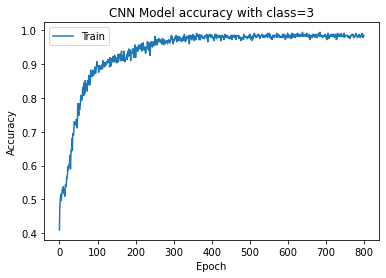

In [140]:
plt.plot(CNN_history.history['accuracy'])
plt.title('CNN Model accuracy with class=3')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

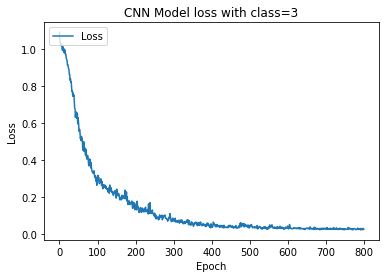

In [141]:
# Plot training loss values
plt.plot(CNN_history.history['loss'])
plt.title('CNN Model loss with class=3')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Loss'], loc='upper left')
plt.show()

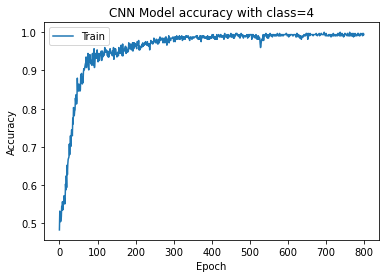

In [142]:
plt.plot(CNN_history1.history['accuracy'])
plt.title('CNN Model accuracy with class=4')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

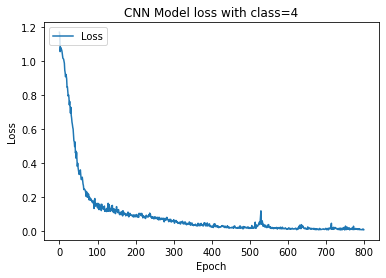

In [155]:
# Plot training loss values
plt.plot(CNN_history1.history['loss'])
plt.title('CNN Model loss with class=4')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Loss'], loc='upper left')
plt.show()

In [158]:
print(accuracy_score(label_valid_y,valid_y_CNN))

print(classification_report(label_valid_y,valid_y_CNN))

print("auc score: ",roc_auc_score(label_valid_y,valid_y_CNN))

0.6690647482014388
              precision    recall  f1-score   support

           0       0.59      0.70      0.64        23
           1       0.82      0.66      0.73        80
           2       0.51      0.67      0.58        36

   micro avg       0.67      0.67      0.67       139
   macro avg       0.64      0.67      0.65       139
weighted avg       0.70      0.67      0.68       139
 samples avg       0.67      0.67      0.67       139

auc score:  0.7505500754984255


In [159]:
print(accuracy_score(label_valid_y1,valid_y_CNN1))

print(classification_report(label_valid_y1,valid_y_CNN1))

0.7142857142857143
              precision    recall  f1-score   support

           0       0.78      0.75      0.77        24
           1       0.77      0.77      0.77        73
           2       0.60      0.60      0.60        43
           3       0.00      0.00      0.00         0

   micro avg       0.71      0.71      0.71       140
   macro avg       0.54      0.53      0.53       140
weighted avg       0.72      0.71      0.72       140
 samples avg       0.71      0.71      0.71       140



D:\Python\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RNN

In [160]:
def create_RNN_model():
    RNN = Sequential()
    RNN.add(Embedding(len(word_index) + 1, word_dimension, weights=[embedding_matrix], input_length = maxlen, trainable=False))

    RNN.add(Bidirectional(LSTM(word_dimension)))
    RNN.add(Dense(word_dimension, activation='relu'))
    RNN.add(Dense(3, activation='softmax'))
    RNN.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
    
    return RNN

In [161]:
RNN_model = create_RNN_model()
RNN_history = RNN_model.fit(feature_train, label_train_y, epochs=800, batch_size=64)

Epoch 1/800
6/6 [==============================] - 2s 34ms/step - loss: 1.0792 - accuracy: 0.4472
Epoch 2/800
6/6 [==============================] - 0s 34ms/step - loss: 1.0140 - accuracy: 0.5186
Epoch 3/800
6/6 [==============================] - 0s 35ms/step - loss: 1.0426 - accuracy: 0.5186
Epoch 4/800
6/6 [==============================] - 0s 33ms/step - loss: 1.0298 - accuracy: 0.5186
Epoch 5/800
6/6 [==============================] - 0s 33ms/step - loss: 1.0154 - accuracy: 0.5186
Epoch 6/800
6/6 [==============================] - 0s 33ms/step - loss: 1.0173 - accuracy: 0.5186
Epoch 7/800
6/6 [==============================] - 0s 33ms/step - loss: 1.0282 - accuracy: 0.5186
Epoch 8/800
6/6 [==============================] - 0s 33ms/step - loss: 1.0335 - accuracy: 0.5186
Epoch 9/800
6/6 [==============================] - 0s 33ms/step - loss: 1.0241 - accuracy: 0.5186
Epoch 10/800
6/6 [==============================] - 0s 34ms/step - loss: 1.0237 - accuracy: 0.5186
Epoch 11/800
6/6 [=

6/6 [==============================] - 0s 33ms/step - loss: 1.0030 - accuracy: 0.5217
Epoch 84/800
6/6 [==============================] - 0s 33ms/step - loss: 1.0071 - accuracy: 0.5186
Epoch 85/800
6/6 [==============================] - 0s 35ms/step - loss: 1.0067 - accuracy: 0.5186
Epoch 86/800
6/6 [==============================] - 0s 33ms/step - loss: 1.0023 - accuracy: 0.5186
Epoch 87/800
6/6 [==============================] - 0s 33ms/step - loss: 1.0042 - accuracy: 0.5342
Epoch 88/800
6/6 [==============================] - 0s 33ms/step - loss: 1.0129 - accuracy: 0.5342
Epoch 89/800
6/6 [==============================] - 0s 34ms/step - loss: 1.0091 - accuracy: 0.5280
Epoch 90/800
6/6 [==============================] - 0s 33ms/step - loss: 1.0060 - accuracy: 0.5186
Epoch 91/800
6/6 [==============================] - 0s 34ms/step - loss: 1.0077 - accuracy: 0.5186
Epoch 92/800
6/6 [==============================] - 0s 33ms/step - loss: 1.0022 - accuracy: 0.5186
Epoch 93/800
6/6 [=====

6/6 [==============================] - 0s 33ms/step - loss: 0.9493 - accuracy: 0.5559
Epoch 166/800
6/6 [==============================] - 0s 33ms/step - loss: 0.9965 - accuracy: 0.5031
Epoch 167/800
6/6 [==============================] - 0s 33ms/step - loss: 0.9416 - accuracy: 0.5652
Epoch 168/800
6/6 [==============================] - 0s 33ms/step - loss: 0.9443 - accuracy: 0.5745
Epoch 169/800
6/6 [==============================] - 0s 34ms/step - loss: 0.9465 - accuracy: 0.5776
Epoch 170/800
6/6 [==============================] - 0s 33ms/step - loss: 0.9499 - accuracy: 0.5745
Epoch 171/800
6/6 [==============================] - 0s 33ms/step - loss: 0.9447 - accuracy: 0.5963
Epoch 172/800
6/6 [==============================] - 0s 34ms/step - loss: 0.9543 - accuracy: 0.5559
Epoch 173/800
6/6 [==============================] - 0s 33ms/step - loss: 0.9389 - accuracy: 0.5870
Epoch 174/800
6/6 [==============================] - 0s 33ms/step - loss: 0.9475 - accuracy: 0.5714
Epoch 175/800


6/6 [==============================] - 0s 33ms/step - loss: 0.8828 - accuracy: 0.6180
Epoch 248/800
6/6 [==============================] - 0s 33ms/step - loss: 0.8684 - accuracy: 0.6180
Epoch 249/800
6/6 [==============================] - 0s 33ms/step - loss: 0.8437 - accuracy: 0.6335
Epoch 250/800
6/6 [==============================] - 0s 33ms/step - loss: 0.8340 - accuracy: 0.6242
Epoch 251/800
6/6 [==============================] - 0s 34ms/step - loss: 0.8395 - accuracy: 0.6211
Epoch 252/800
6/6 [==============================] - 0s 33ms/step - loss: 0.8241 - accuracy: 0.6429
Epoch 253/800
6/6 [==============================] - 0s 33ms/step - loss: 0.8023 - accuracy: 0.6584
Epoch 254/800
6/6 [==============================] - 0s 33ms/step - loss: 0.8198 - accuracy: 0.6460
Epoch 255/800
6/6 [==============================] - 0s 33ms/step - loss: 0.8313 - accuracy: 0.6491
Epoch 256/800
6/6 [==============================] - 0s 33ms/step - loss: 0.8395 - accuracy: 0.6118
Epoch 257/800


6/6 [==============================] - 0s 33ms/step - loss: 0.7929 - accuracy: 0.6335
Epoch 330/800
6/6 [==============================] - 0s 33ms/step - loss: 0.7898 - accuracy: 0.6553
Epoch 331/800
6/6 [==============================] - 0s 33ms/step - loss: 0.7814 - accuracy: 0.6522
Epoch 332/800
6/6 [==============================] - 0s 33ms/step - loss: 0.7589 - accuracy: 0.6615
Epoch 333/800
6/6 [==============================] - 0s 33ms/step - loss: 0.7484 - accuracy: 0.6770
Epoch 334/800
6/6 [==============================] - 0s 34ms/step - loss: 0.7421 - accuracy: 0.6863
Epoch 335/800
6/6 [==============================] - 0s 33ms/step - loss: 0.7440 - accuracy: 0.6770
Epoch 336/800
6/6 [==============================] - 0s 33ms/step - loss: 0.7496 - accuracy: 0.6615
Epoch 337/800
6/6 [==============================] - 0s 33ms/step - loss: 0.7527 - accuracy: 0.6770
Epoch 338/800
6/6 [==============================] - 0s 33ms/step - loss: 0.7319 - accuracy: 0.6708
Epoch 339/800


6/6 [==============================] - 0s 33ms/step - loss: 0.5958 - accuracy: 0.7671
Epoch 412/800
6/6 [==============================] - 0s 34ms/step - loss: 0.6407 - accuracy: 0.7329
Epoch 413/800
6/6 [==============================] - 0s 33ms/step - loss: 0.6019 - accuracy: 0.7702
Epoch 414/800
6/6 [==============================] - 0s 33ms/step - loss: 0.5836 - accuracy: 0.7702
Epoch 415/800
6/6 [==============================] - 0s 33ms/step - loss: 0.5950 - accuracy: 0.7640
Epoch 416/800
6/6 [==============================] - 0s 33ms/step - loss: 0.5505 - accuracy: 0.7671
Epoch 417/800
6/6 [==============================] - 0s 33ms/step - loss: 0.5620 - accuracy: 0.7857
Epoch 418/800
6/6 [==============================] - 0s 33ms/step - loss: 0.5512 - accuracy: 0.7733
Epoch 419/800
6/6 [==============================] - 0s 33ms/step - loss: 0.5548 - accuracy: 0.7950
Epoch 420/800
6/6 [==============================] - 0s 33ms/step - loss: 0.6089 - accuracy: 0.7702
Epoch 421/800


6/6 [==============================] - 0s 34ms/step - loss: 0.3987 - accuracy: 0.8416
Epoch 494/800
6/6 [==============================] - 0s 34ms/step - loss: 0.3883 - accuracy: 0.8509
Epoch 495/800
6/6 [==============================] - 0s 33ms/step - loss: 0.4090 - accuracy: 0.8354
Epoch 496/800
6/6 [==============================] - 0s 33ms/step - loss: 0.5146 - accuracy: 0.7981
Epoch 497/800
6/6 [==============================] - 0s 33ms/step - loss: 0.5086 - accuracy: 0.7857
Epoch 498/800
6/6 [==============================] - 0s 33ms/step - loss: 0.5028 - accuracy: 0.7857
Epoch 499/800
6/6 [==============================] - 0s 34ms/step - loss: 0.4473 - accuracy: 0.8416
Epoch 500/800
6/6 [==============================] - 0s 33ms/step - loss: 0.4671 - accuracy: 0.8168
Epoch 501/800
6/6 [==============================] - 0s 33ms/step - loss: 0.4219 - accuracy: 0.8540
Epoch 502/800
6/6 [==============================] - 0s 34ms/step - loss: 0.4061 - accuracy: 0.8602
Epoch 503/800


6/6 [==============================] - 0s 34ms/step - loss: 0.2675 - accuracy: 0.9006
Epoch 576/800
6/6 [==============================] - 0s 34ms/step - loss: 0.2633 - accuracy: 0.9130
Epoch 577/800
6/6 [==============================] - 0s 33ms/step - loss: 0.2670 - accuracy: 0.9130
Epoch 578/800
6/6 [==============================] - 0s 35ms/step - loss: 0.2538 - accuracy: 0.9224
Epoch 579/800
6/6 [==============================] - 0s 37ms/step - loss: 0.2545 - accuracy: 0.9037
Epoch 580/800
6/6 [==============================] - 0s 35ms/step - loss: 0.2535 - accuracy: 0.9068
Epoch 581/800
6/6 [==============================] - 0s 37ms/step - loss: 0.2519 - accuracy: 0.9037
Epoch 582/800
6/6 [==============================] - 0s 38ms/step - loss: 0.2455 - accuracy: 0.9130
Epoch 583/800
6/6 [==============================] - 0s 35ms/step - loss: 0.2399 - accuracy: 0.9161
Epoch 584/800
6/6 [==============================] - 0s 34ms/step - loss: 0.2438 - accuracy: 0.9130
Epoch 585/800


6/6 [==============================] - 0s 33ms/step - loss: 0.2345 - accuracy: 0.9099
Epoch 658/800
6/6 [==============================] - 0s 34ms/step - loss: 0.2148 - accuracy: 0.9224
Epoch 659/800
6/6 [==============================] - 0s 34ms/step - loss: 0.2115 - accuracy: 0.9348
Epoch 660/800
6/6 [==============================] - 0s 33ms/step - loss: 0.2077 - accuracy: 0.9410
Epoch 661/800
6/6 [==============================] - 0s 33ms/step - loss: 0.2005 - accuracy: 0.9410
Epoch 662/800
6/6 [==============================] - 0s 34ms/step - loss: 0.1923 - accuracy: 0.9348
Epoch 663/800
6/6 [==============================] - 0s 33ms/step - loss: 0.1934 - accuracy: 0.9441
Epoch 664/800
6/6 [==============================] - 0s 33ms/step - loss: 0.1873 - accuracy: 0.9379
Epoch 665/800
6/6 [==============================] - 0s 33ms/step - loss: 0.1785 - accuracy: 0.9410
Epoch 666/800
6/6 [==============================] - 0s 35ms/step - loss: 0.1752 - accuracy: 0.9379
Epoch 667/800


6/6 [==============================] - 0s 34ms/step - loss: 0.1646 - accuracy: 0.9503
Epoch 740/800
6/6 [==============================] - 0s 33ms/step - loss: 0.1690 - accuracy: 0.9472
Epoch 741/800
6/6 [==============================] - 0s 33ms/step - loss: 0.1710 - accuracy: 0.9348
Epoch 742/800
6/6 [==============================] - 0s 33ms/step - loss: 0.1557 - accuracy: 0.9472
Epoch 743/800
6/6 [==============================] - 0s 33ms/step - loss: 0.1395 - accuracy: 0.9565
Epoch 744/800
6/6 [==============================] - 0s 33ms/step - loss: 0.1582 - accuracy: 0.9472
Epoch 745/800
6/6 [==============================] - 0s 32ms/step - loss: 0.1390 - accuracy: 0.9596
Epoch 746/800
6/6 [==============================] - 0s 33ms/step - loss: 0.1317 - accuracy: 0.9565
Epoch 747/800
6/6 [==============================] - 0s 35ms/step - loss: 0.1270 - accuracy: 0.9627
Epoch 748/800
6/6 [==============================] - 0s 33ms/step - loss: 0.1210 - accuracy: 0.9596
Epoch 749/800


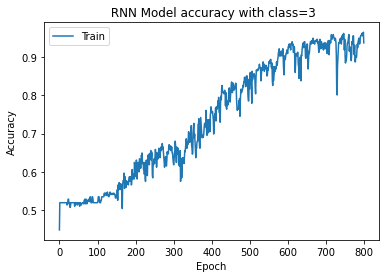

In [162]:
# Plot training & validation accuracy
plt.plot(RNN_history.history['accuracy'])
plt.title(' RNN Model accuracy with class=3')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

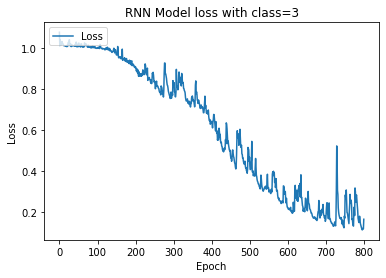

In [163]:
# Plot training loss values
plt.plot(RNN_history.history['loss'])
plt.title('RNN Model loss with class=3')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Loss'], loc='upper left')
plt.show()

In [164]:
# validation with the RNN 
y_valid_RNN = RNN_model.predict(feature_valid)
valid_y_RNN = y_valid_RNN.copy()
for i in range(len(y_valid_RNN)):
    j = np.where(y_valid_RNN[i] == np.amax(y_valid_RNN[i]))
    valid_y_RNN[i] = [0, 0, 0]
    valid_y_RNN[i][j] = 1
  
# print acc and report
print(accuracy_score(label_valid_y,valid_y_RNN))

print(classification_report(label_valid_y,valid_y_RNN))

print("auc score: ",roc_auc_score(label_valid_y,valid_y_RNN))

5/5 [==============================] - 0s 8ms/step
0.6474820143884892
              precision    recall  f1-score   support

           0       0.52      0.61      0.56        23
           1       0.78      0.75      0.76        80
           2       0.46      0.44      0.45        36

   micro avg       0.65      0.65      0.65       139
   macro avg       0.58      0.60      0.59       139
weighted avg       0.65      0.65      0.65       139
 samples avg       0.65      0.65      0.65       139

auc score:  0.7030782530772169


In [165]:
def create_RNN_model1():
    RNN = Sequential()
    RNN.add(Embedding(len(word_index1) + 1, word_dimension, weights=[embedding_matrix1], input_length = maxlen, trainable=False))

    RNN.add(Bidirectional(LSTM(word_dimension)))
    RNN.add(Dense(word_dimension, activation='relu'))
    RNN.add(Dense(4, activation='softmax'))
    RNN.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
    
    return RNN

In [166]:
RNN_model1 = create_RNN_model1()
RNN_history1 = RNN_model1.fit(feature_train1, label_train_y1, epochs=800, batch_size=64)

Epoch 1/800
6/6 [==============================] - 2s 33ms/step - loss: 1.1794 - accuracy: 0.5323
Epoch 2/800
6/6 [==============================] - 0s 33ms/step - loss: 1.1087 - accuracy: 0.5354
Epoch 3/800
6/6 [==============================] - 0s 33ms/step - loss: 1.0761 - accuracy: 0.5354
Epoch 4/800
6/6 [==============================] - 0s 33ms/step - loss: 1.0640 - accuracy: 0.5354
Epoch 5/800
6/6 [==============================] - 0s 33ms/step - loss: 1.0795 - accuracy: 0.5354
Epoch 6/800
6/6 [==============================] - 0s 33ms/step - loss: 1.0567 - accuracy: 0.5354
Epoch 7/800
6/6 [==============================] - 0s 33ms/step - loss: 1.0572 - accuracy: 0.5354
Epoch 8/800
6/6 [==============================] - 0s 33ms/step - loss: 1.0664 - accuracy: 0.5354
Epoch 9/800
6/6 [==============================] - 0s 34ms/step - loss: 1.0570 - accuracy: 0.5354
Epoch 10/800
6/6 [==============================] - 0s 34ms/step - loss: 1.0537 - accuracy: 0.5354
Epoch 11/800
6/6 [=

6/6 [==============================] - 0s 33ms/step - loss: 1.0125 - accuracy: 0.5662
Epoch 84/800
6/6 [==============================] - 0s 33ms/step - loss: 1.0103 - accuracy: 0.5631
Epoch 85/800
6/6 [==============================] - 0s 33ms/step - loss: 1.0047 - accuracy: 0.5600
Epoch 86/800
6/6 [==============================] - 0s 34ms/step - loss: 1.0057 - accuracy: 0.5631
Epoch 87/800
6/6 [==============================] - 0s 33ms/step - loss: 1.0009 - accuracy: 0.5723
Epoch 88/800
6/6 [==============================] - 0s 33ms/step - loss: 0.9991 - accuracy: 0.5631
Epoch 89/800
6/6 [==============================] - 0s 33ms/step - loss: 0.9974 - accuracy: 0.5662
Epoch 90/800
6/6 [==============================] - 0s 35ms/step - loss: 0.9963 - accuracy: 0.5785
Epoch 91/800
6/6 [==============================] - 0s 33ms/step - loss: 0.9916 - accuracy: 0.5723
Epoch 92/800
6/6 [==============================] - 0s 34ms/step - loss: 0.9923 - accuracy: 0.5692
Epoch 93/800
6/6 [=====

6/6 [==============================] - 0s 34ms/step - loss: 0.9490 - accuracy: 0.6062
Epoch 166/800
6/6 [==============================] - 0s 34ms/step - loss: 0.9755 - accuracy: 0.5723
Epoch 167/800
6/6 [==============================] - 0s 33ms/step - loss: 0.9689 - accuracy: 0.5877
Epoch 168/800
6/6 [==============================] - 0s 34ms/step - loss: 0.9559 - accuracy: 0.5877
Epoch 169/800
6/6 [==============================] - 0s 33ms/step - loss: 0.9520 - accuracy: 0.6062
Epoch 170/800
6/6 [==============================] - 0s 34ms/step - loss: 0.9455 - accuracy: 0.5908
Epoch 171/800
6/6 [==============================] - 0s 34ms/step - loss: 0.9393 - accuracy: 0.5969
Epoch 172/800
6/6 [==============================] - 0s 34ms/step - loss: 0.9452 - accuracy: 0.5969
Epoch 173/800
6/6 [==============================] - 0s 34ms/step - loss: 0.9432 - accuracy: 0.5908
Epoch 174/800
6/6 [==============================] - 0s 34ms/step - loss: 0.9399 - accuracy: 0.6000
Epoch 175/800


6/6 [==============================] - 0s 34ms/step - loss: 0.9209 - accuracy: 0.5908
Epoch 248/800
6/6 [==============================] - 0s 35ms/step - loss: 0.9039 - accuracy: 0.6092
Epoch 249/800
6/6 [==============================] - 0s 33ms/step - loss: 0.9040 - accuracy: 0.6215
Epoch 250/800
6/6 [==============================] - 0s 34ms/step - loss: 0.8913 - accuracy: 0.6369
Epoch 251/800
6/6 [==============================] - 0s 33ms/step - loss: 0.8914 - accuracy: 0.6462
Epoch 252/800
6/6 [==============================] - 0s 34ms/step - loss: 0.8959 - accuracy: 0.6400
Epoch 253/800
6/6 [==============================] - 0s 35ms/step - loss: 0.8871 - accuracy: 0.6062
Epoch 254/800
6/6 [==============================] - 0s 35ms/step - loss: 0.8788 - accuracy: 0.6277
Epoch 255/800
6/6 [==============================] - 0s 34ms/step - loss: 0.8797 - accuracy: 0.6308
Epoch 256/800
6/6 [==============================] - 0s 36ms/step - loss: 0.8935 - accuracy: 0.6215
Epoch 257/800


6/6 [==============================] - 0s 35ms/step - loss: 0.8149 - accuracy: 0.6646
Epoch 330/800
6/6 [==============================] - 0s 35ms/step - loss: 0.7954 - accuracy: 0.6708
Epoch 331/800
6/6 [==============================] - 0s 34ms/step - loss: 0.7722 - accuracy: 0.6800
Epoch 332/800
6/6 [==============================] - 0s 37ms/step - loss: 0.7639 - accuracy: 0.6615
Epoch 333/800
6/6 [==============================] - 0s 36ms/step - loss: 0.7438 - accuracy: 0.6954
Epoch 334/800
6/6 [==============================] - 0s 36ms/step - loss: 0.7608 - accuracy: 0.6831
Epoch 335/800
6/6 [==============================] - 0s 35ms/step - loss: 0.7302 - accuracy: 0.7169
Epoch 336/800
6/6 [==============================] - 0s 34ms/step - loss: 0.7464 - accuracy: 0.6554
Epoch 337/800
6/6 [==============================] - 0s 36ms/step - loss: 0.7175 - accuracy: 0.7169
Epoch 338/800
6/6 [==============================] - 0s 34ms/step - loss: 0.7723 - accuracy: 0.6831
Epoch 339/800


6/6 [==============================] - 0s 35ms/step - loss: 0.5298 - accuracy: 0.7969
Epoch 412/800
6/6 [==============================] - 0s 36ms/step - loss: 0.6116 - accuracy: 0.7569
Epoch 413/800
6/6 [==============================] - 0s 33ms/step - loss: 0.6017 - accuracy: 0.7477
Epoch 414/800
6/6 [==============================] - 0s 33ms/step - loss: 0.6104 - accuracy: 0.7538
Epoch 415/800
6/6 [==============================] - 0s 34ms/step - loss: 0.5439 - accuracy: 0.7754
Epoch 416/800
6/6 [==============================] - 0s 34ms/step - loss: 0.5350 - accuracy: 0.7815
Epoch 417/800
6/6 [==============================] - 0s 35ms/step - loss: 0.5250 - accuracy: 0.7938
Epoch 418/800
6/6 [==============================] - 0s 36ms/step - loss: 0.5210 - accuracy: 0.8062
Epoch 419/800
6/6 [==============================] - 0s 36ms/step - loss: 0.5397 - accuracy: 0.7815
Epoch 420/800
6/6 [==============================] - 0s 35ms/step - loss: 0.5208 - accuracy: 0.8123
Epoch 421/800


6/6 [==============================] - 0s 33ms/step - loss: 0.4497 - accuracy: 0.8338
Epoch 494/800
6/6 [==============================] - 0s 34ms/step - loss: 0.4423 - accuracy: 0.8492
Epoch 495/800
6/6 [==============================] - 0s 33ms/step - loss: 0.4573 - accuracy: 0.8154
Epoch 496/800
6/6 [==============================] - 0s 34ms/step - loss: 0.4344 - accuracy: 0.8400
Epoch 497/800
6/6 [==============================] - 0s 36ms/step - loss: 0.4331 - accuracy: 0.8646
Epoch 498/800
6/6 [==============================] - 0s 36ms/step - loss: 0.4322 - accuracy: 0.8431
Epoch 499/800
6/6 [==============================] - 0s 34ms/step - loss: 0.4232 - accuracy: 0.8523
Epoch 500/800
6/6 [==============================] - 0s 35ms/step - loss: 0.4330 - accuracy: 0.8431
Epoch 501/800
6/6 [==============================] - 0s 34ms/step - loss: 0.4329 - accuracy: 0.8400
Epoch 502/800
6/6 [==============================] - 0s 36ms/step - loss: 0.4413 - accuracy: 0.8338
Epoch 503/800


6/6 [==============================] - 0s 38ms/step - loss: 0.3765 - accuracy: 0.8431
Epoch 576/800
6/6 [==============================] - 0s 35ms/step - loss: 0.4384 - accuracy: 0.8308
Epoch 577/800
6/6 [==============================] - 0s 34ms/step - loss: 0.3897 - accuracy: 0.8492
Epoch 578/800
6/6 [==============================] - 0s 35ms/step - loss: 0.3542 - accuracy: 0.8585
Epoch 579/800
6/6 [==============================] - 0s 34ms/step - loss: 0.3599 - accuracy: 0.8462
Epoch 580/800
6/6 [==============================] - 0s 33ms/step - loss: 0.3672 - accuracy: 0.8615
Epoch 581/800
6/6 [==============================] - 0s 34ms/step - loss: 0.3753 - accuracy: 0.8554
Epoch 582/800
6/6 [==============================] - 0s 33ms/step - loss: 0.3866 - accuracy: 0.8369
Epoch 583/800
6/6 [==============================] - 0s 35ms/step - loss: 0.5229 - accuracy: 0.8000
Epoch 584/800
6/6 [==============================] - 0s 34ms/step - loss: 0.4274 - accuracy: 0.8246
Epoch 585/800


6/6 [==============================] - 0s 33ms/step - loss: 0.3484 - accuracy: 0.8708
Epoch 658/800
6/6 [==============================] - 0s 34ms/step - loss: 0.3571 - accuracy: 0.8400
Epoch 659/800
6/6 [==============================] - 0s 34ms/step - loss: 0.3313 - accuracy: 0.8554
Epoch 660/800
6/6 [==============================] - 0s 33ms/step - loss: 0.3344 - accuracy: 0.8585
Epoch 661/800
6/6 [==============================] - 0s 33ms/step - loss: 0.3137 - accuracy: 0.8800
Epoch 662/800
6/6 [==============================] - 0s 34ms/step - loss: 0.3050 - accuracy: 0.8769
Epoch 663/800
6/6 [==============================] - 0s 34ms/step - loss: 0.3319 - accuracy: 0.8554
Epoch 664/800
6/6 [==============================] - 0s 34ms/step - loss: 0.3263 - accuracy: 0.8585
Epoch 665/800
6/6 [==============================] - 0s 33ms/step - loss: 0.3607 - accuracy: 0.8462
Epoch 666/800
6/6 [==============================] - 0s 33ms/step - loss: 0.3567 - accuracy: 0.8431
Epoch 667/800


6/6 [==============================] - 0s 34ms/step - loss: 0.3311 - accuracy: 0.8831
Epoch 740/800
6/6 [==============================] - 0s 34ms/step - loss: 0.3233 - accuracy: 0.8708
Epoch 741/800
6/6 [==============================] - 0s 35ms/step - loss: 0.3076 - accuracy: 0.8862
Epoch 742/800
6/6 [==============================] - 0s 35ms/step - loss: 0.2854 - accuracy: 0.8831
Epoch 743/800
6/6 [==============================] - 0s 35ms/step - loss: 0.2694 - accuracy: 0.9046
Epoch 744/800
6/6 [==============================] - 0s 34ms/step - loss: 0.2505 - accuracy: 0.9169
Epoch 745/800
6/6 [==============================] - 0s 34ms/step - loss: 0.2321 - accuracy: 0.9015
Epoch 746/800
6/6 [==============================] - 0s 33ms/step - loss: 0.2355 - accuracy: 0.9077
Epoch 747/800
6/6 [==============================] - 0s 34ms/step - loss: 0.2219 - accuracy: 0.9200
Epoch 748/800
6/6 [==============================] - 0s 33ms/step - loss: 0.2233 - accuracy: 0.9015
Epoch 749/800


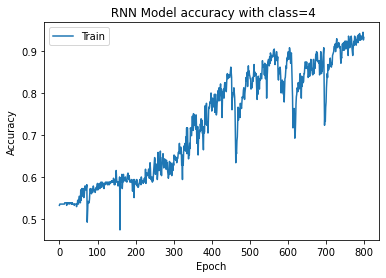

In [167]:
# Plot training & validation accuracy
plt.plot(RNN_history1.history['accuracy'])
plt.title(' RNN Model accuracy with class=4')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

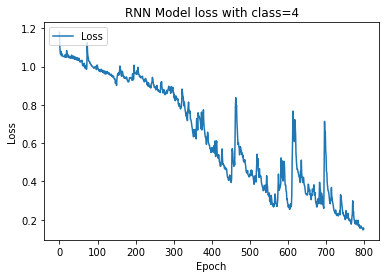

In [168]:
# Plot training loss values
plt.plot(RNN_history1.history['loss'])
plt.title('RNN Model loss with class=4')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Loss'], loc='upper left')
plt.show()

In [169]:
# validation with the RNN 
y_valid_RNN1 = RNN_model1.predict(feature_valid1)
valid_y_RNN1 = y_valid_RNN1.copy()
for i in range(len(y_valid_RNN1)):
    j = np.where(y_valid_RNN1[i] == np.amax(y_valid_RNN1[i]))
    valid_y_RNN1[i] = [0, 0, 0, 0]
    valid_y_RNN1[i][j] = 1
  
# print acc and report
print(accuracy_score(label_valid_y1,valid_y_RNN1))

print(classification_report(label_valid_y1,valid_y_RNN1))

print("auc score: ",roc_auc_score(label_valid_y,valid_y_CNN))

5/5 [==============================] - 0s 9ms/step
0.6142857142857143
              precision    recall  f1-score   support

           0       0.76      0.79      0.78        24
           1       0.71      0.56      0.63        73
           2       0.46      0.60      0.53        43
           3       0.00      0.00      0.00         0

   micro avg       0.61      0.61      0.61       140
   macro avg       0.48      0.49      0.48       140
weighted avg       0.64      0.61      0.62       140
 samples avg       0.61      0.61      0.61       140



D:\Python\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Prediction

In [170]:
y_pred_CNN = CNN_model.predict(feature_test)
pred_y_CNN = y_pred_CNN.copy()
for i in range(len(y_pred_CNN)):
    j = np.where(y_pred_CNN[i] == np.amax(y_pred_CNN[i]))
    pred_y_CNN[i] = [0, 0, 0]
    pred_y_CNN[i][j] = 1
    
y_pred_RNN = RNN_model.predict(feature_test)
pred_y_RNN = y_pred_RNN.copy()
for i in range(len(y_pred_RNN)):
    j = np.where(y_pred_RNN[i] == np.amax(y_pred_RNN[i]))
    pred_y_RNN[i] = [0, 0, 0]
    pred_y_RNN[i][j] = 1
    


3/3 [==============================] - 0s 8ms/step


In [171]:
cnn_pred_y = pd.Series(np.zeros(len(pred_y_CNN)))
for i in range(len(pred_y_CNN)):
    j = np.where(pred_y_CNN[i] == 1)
    if j == (np.array([0]),):
        cnn_pred_y[i] = 'Balanced Fund (Low Risk)'
    elif j == (np.array([1]),):
        cnn_pred_y[i] = 'Equity Long Only (Low Risk)'
    elif j == (np.array([2]),):
        cnn_pred_y[i] = 'Fixed Income Long Only (Low Risk)'


cnn_predict = pd.DataFrame({'fund name':test_funds,'CNN prediction':cnn_pred_y})
print(cnn_predict)

                                            fund name  \
0                      AB All Market Income Portfolio   
1                 AB All Market Real Return Portfolio   
2                                AB Arizona Portfolio   
3                   AB Asia ex-Japan Equity Portfolio   
4               AB Balanced Wealth Strategy Portfolio   
..                                                ...   
74  T. Rowe Price Institutional International Core...   
75  T. Rowe Price Institutional International Grow...   
76                                     UTILITIES FUND   
77                    Virtus Enhanced U.S. Equity ETF   
78                 Virtus Newfleet Dynamic Credit ETF   

                       CNN prediction  
0         Equity Long Only (Low Risk)  
1         Equity Long Only (Low Risk)  
2         Equity Long Only (Low Risk)  
3   Fixed Income Long Only (Low Risk)  
4            Balanced Fund (Low Risk)  
..                                ...  
74        Equity Long Only (Low Ris

In [172]:
rnn_pred_y = pd.Series(np.zeros(len(pred_y_RNN)))
for i in range(len(pred_y_RNN)):
    j = np.where(pred_y_RNN[i] == 1)
    if j == (np.array([0]),):
        rnn_pred_y[i] = 'Balanced Fund (Low Risk)'
    elif j == (np.array([1]),):
        rnn_pred_y[i] = 'Equity Long Only (Low Risk)'
    elif j == (np.array([2]),):
        rnn_pred_y[i] = 'Fixed Income Long Only (Low Risk)'


rnn_predict = pd.DataFrame({'fund name':test_funds,'RNN prediction':rnn_pred_y})
print(rnn_predict)

                                            fund name  \
0                      AB All Market Income Portfolio   
1                 AB All Market Real Return Portfolio   
2                                AB Arizona Portfolio   
3                   AB Asia ex-Japan Equity Portfolio   
4               AB Balanced Wealth Strategy Portfolio   
..                                                ...   
74  T. Rowe Price Institutional International Core...   
75  T. Rowe Price Institutional International Grow...   
76                                     UTILITIES FUND   
77                    Virtus Enhanced U.S. Equity ETF   
78                 Virtus Newfleet Dynamic Credit ETF   

                       RNN prediction  
0   Fixed Income Long Only (Low Risk)  
1         Equity Long Only (Low Risk)  
2            Balanced Fund (Low Risk)  
3         Equity Long Only (Low Risk)  
4         Equity Long Only (Low Risk)  
..                                ...  
74        Equity Long Only (Low Ris